# RPGF3 Projects on Open Source Observer

###  RPGF3 List ✨

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import json
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

LIST_NAME = "OSS Projects on Open Source Observer"
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-07_RPGF3xOSO.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_DESC = " ".join([
                "This list awards 50K OP tokens to any RPGF3 project that is represented on",
                "https://opensource.observer. Only projects with unique, public GitHub repos",
                "included in their application have been indexed by OSO. It awards an extra 25K tokens",
                "to projects that included a contract address or NPM package url in their application,",
                "or that were in a prior RPGF round."
                ]) 

LIST_DESC += " ".join([
                " Note: lists generated by the OSO team do not include OSO in them in order to comply",
                "with voting rules, so please consider adding our project to your ballot separately."
                ])

JSON_PATH = DATA_DIR + "lists/RPGF3xOSO.json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()

slugs = slugs[slugs!='opensource-observer']
del slugs_to_ids['opensource-observer']

#duplicates = oso.check_duplicate_slugs()

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)

query = f"""
    WITH Rpgf AS (
        SELECT DISTINCT p.slug
        FROM collection c
        JOIN collection_projects_project cpp ON c."id" = cpp."collectionId"
        JOIN project p on cpp."projectId" = p."id"
        WHERE c.slug IN ('op-rpgf1', 'op-rpgf2')
    )
    , Counter AS (
        SELECT p.slug, COUNT(DISTINCT a.id) AS artifact_count
        FROM project p
        JOIN project_artifacts_artifact paa ON p."id" = paa."projectId"
        JOIN artifact a ON paa."artifactId" = a."id"
        WHERE 
            p.slug IN ('{slugs_list}') 
            AND a.namespace <> 'ETHEREUM' 
            AND a.type IN ('CONTRACT_ADDRESS', 'FACTORY_ADDRESS', 'NPM_PACKAGE')
        GROUP BY p.slug
    )
    SELECT 
        p.slug,
        CASE WHEN p.slug IN (SELECT slug FROM Rpgf) THEN 1 ELSE 0 END AS past_rpgf,
        CASE WHEN (SELECT artifact_count FROM Counter WHERE Counter.slug = p.slug) > 0 THEN 1 ELSE 0 END AS has_artifact_count
    FROM project p
    WHERE p.slug IN ('{slugs_list}')    
    ORDER BY p.slug;     
"""
results = execute_query(query, col_names=False)

In [5]:
# transform query results

rpgf_oso = {p: 25000*(r|a)+50000 for (p,r,a) in results}
rpgf_oso

{'0x-splits': 75000,
 '1w3': 75000,
 'abi-to-sol-gnidan': 50000,
 'across': 75000,
 'acrypto-s': 75000,
 'aerodrome-finance': 50000,
 'aestus-relay': 50000,
 'agoraxyz': 75000,
 'alchemyplatform': 75000,
 'alembic-tech': 50000,
 'alloy-rs': 50000,
 'alphadayhq': 50000,
 'another-world': 75000,
 'anotherblock': 75000,
 'ape-framework': 75000,
 'arbiter-primitivefinance': 50000,
 'arpa-network': 50000,
 'attestation-station-interface-sbvegan': 75000,
 'attestation-visualizer-xvoorvaa': 50000,
 'aw-labs': 75000,
 'awesome-optimism-lucas-op': 50000,
 'aya-labs': 50000,
 'bankless-academy': 75000,
 'bankless-card': 50000,
 'banklessdao': 75000,
 'basepunkorg': 50000,
 'beacon-chain': 75000,
 'blobscan': 75000,
 'blockhead-darryl-yeo': 50000,
 'blocknative': 50000,
 'blockscout': 75000,
 'blst-supranational': 75000,
 'boardroom-inc': 75000,
 'bonding-curves': 50000,
 'bootnodedev': 50000,
 'brightid': 75000,
 'buidlguidl': 75000,
 'bunnyai-justindomingue': 50000,
 'bwarelabs': 75000,
 'candi

# Generate the list data

In [6]:
award_amt = sum(rpgf_oso.values())
award_amt

19850000

In [7]:
named_list = listify(rpgf_oso, award_amt)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

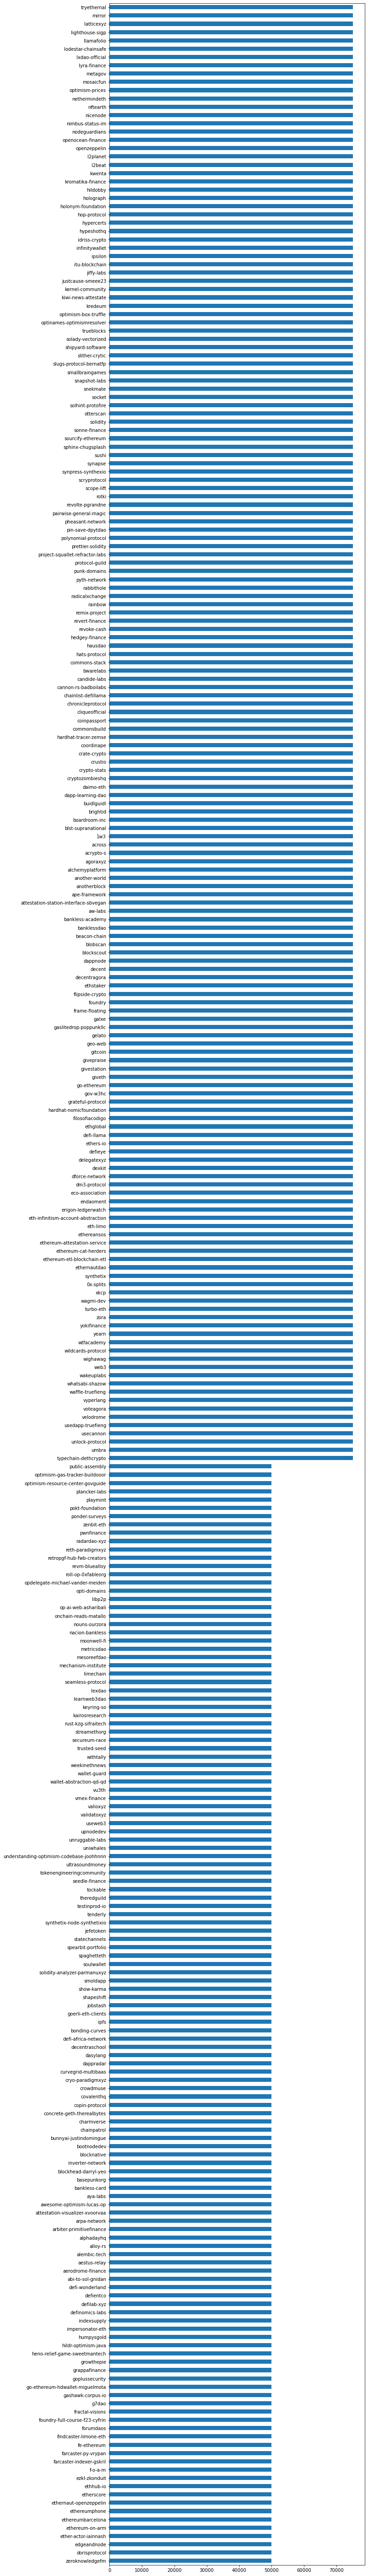

In [8]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

# Create a unique list per category

In [11]:
category_lists = {}

category_labels = {
    'COLLECTIVE_GOVERNANCE': 'Collective Governance',
    'DEVELOPER_ECOSYSTEM': 'Developer Ecosystem', 
    'END_USER_EXPERIENCE_AND_ADOPTION': 'End User Experience and Adoption', 
    'OP_STACK': 'OP Stack'
}

eas_metadata = create_eas_json(rpgf_list, LIST_NAME, LIST_LINK, LIST_DESC, category_labels.keys())
with open(json_path, "w") as f:
    json.dump(metadata, f, indent=4)

for category, label in category_labels.items():
    
    metadata = eas_metadata.copy()
    metadata["impactCategory"] = category
    metadata["listDescription"] = metadata["listDescription"].replace("OSS", label)
    metadata["impactEvaluationDescription"] = metadata["impactEvaluationDescription"].replace("RPGF3 project", f"RPGF3 project in the '{label}' impact catetogry")
    ids = list(oso.df[oso.df["Tags"].apply(lambda x: category in x)]['Project ID'])
    projects = []
    for project in eas_metadata["listContent"]:
        if project['RPGF3_Application_UID'] in ids:
            projects.append(project)
    metadata["listContent"] = projects
    category_lists.update({category: metadata})
    
    json_path = JSON_PATH.replace("xOSO", f"xOSO_{category}")
    with open(json_path, "w") as f:
        json.dump(metadata, f, indent=4)
        
